In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

### Write function as I explore in notebook

In [2]:
# Read data 
# specify file name

exp_no = 104
file_name = f"{exp_no}_SHT_SMD.txt"
file_path = f"../data/01_raw/{file_name}"
df = pd.read_csv(file_path, sep=',', usecols=['timestamp', 'SHT40_temp', 'SHT40_Humidity', 'A1_Sensor', 'A1_Resistance'])




In [3]:
# identify all peaks including high and low peaks, and then find the index of smaller peak by compariing
# the height of two adjacent peaks
# put the index of the smaller and larger peaks into two lists

def _hi_lo_peak(x: pd.DataFrame) -> pd.DataFrame:
    peaks, properties = find_peaks(x['A1_Sensor'], width=50, height=1)
    peak_heights = properties['peak_heights']
# Determine smaller and larger peaks
    smaller_peaks, larger_peaks = [], []
    for i in range(len(peaks) - 1):
        if peak_heights[i] > peak_heights[i + 1]:
            larger_peaks.append(peaks[i])
            smaller_peaks.append(peaks[i + 1])
    # smaller_peaks_df = x.iloc[smaller_peaks]
    return smaller_peaks

In [109]:
def preprocess_data_stack(sp: pd.DataFrame, df: pd.DataFrame) -> pd.DataFrame:
    df_stacked_list = []
    for i in range(len(sp) - 1):
        df_subset = df.iloc[sp[i]:sp[i + 1]].copy()
        df_subset['exp_no'] = i
        df_subset['timestamp'] -= df_subset['timestamp'].iloc[0]
        df_stacked_list.append(df_subset)
        df_stacked = pd.concat(df_stacked_list, ignore_index=True)
    return df_stacked

In [110]:
df_stacked = preprocess_data_stack(_hi_lo_peak(df), df)

In [111]:
df_stacked.tail()

,timestamp,SHT40_temp,SHT40_Humidity,A1_Sensor,A1_Resistance,exp_no
844593,181900,26.56,40.67,1598.0,2311577.00,231
844594,181949,26.56,40.72,1596.0,2314661.50,231
844595,182000,26.58,40.80,1597.0,2313118.25,231
844596,182050,26.57,40.84,1601.0,2306964.50,231
844597,182100,26.58,40.89,1601.0,2306964.50,231


# Bucketing
Bucketing all time variable under uniformed buckets to align features
- Define minimum t and maximum t
- Form a bucket per 200ms
- Average n number of values in the bucket

examine all exp_no
determine min and max that will be applied uniformly


In [112]:
# group experiments by using groupby function
# create a new column called bin
# the number of bin is predefined by user i.e., 1500
# group the data entries into 1500 bins
# average the values within each bin

def _group_by_bin(df_stacked: pd.DataFrame, num_bins: int) -> pd.DataFrame:
    df_list = []
    grouped = df_stacked.groupby('exp_no')
    for name, group in grouped:
        group['bin'] = pd.cut(group['timestamp'], bins=num_bins, labels=False)
        df_list.append(group)
    return pd.concat(df_list)

bin_df = _group_by_bin(df_stacked, 1500)
# bucketed.tail()

In [113]:
# check all exp_no have the same number of bins
# if they are all the same print 1 if not print 0

def _check_bins(df: pd.DataFrame) -> bool:
    grouped = df.groupby('exp_no')
    unique_bins = None
    for name, group in grouped:
        if unique_bins is None:
            unique_bins = len(group['bin'].unique())
        elif len(group['bin'].unique()) != unique_bins:
            return False
    return True

_check_bins(bin_df)


True

In [114]:
# average data within each bucket to give only one value per bucket
# group by experiment number and timestamp_bucket
# drop timestamp column
# calculate mean of all columns


def _average_bin(bin_df: pd.DataFrame) -> pd.DataFrame:
    bin_df = bin_df.drop(columns=['timestamp'])
    grouped = bin_df.groupby(['exp_no', 'bin']).mean()
    return grouped.reset_index()

In [115]:
# save averaged data to csv in intermediate folder
averaged = _average_bin(bin_df)
# averaged.to_csv(f"../data/02_intermediate/norm_averaged_bin.csv")

In [ ]:
# return a group of exp_no data
# group by exp_no
grouped = averaged.groupby('exp_no')
grouped.get_group(0)

In [ ]:
def get_percentile_data(df, percentile):
    """
    Returns the data up to the specified percentile based on the 'bin' column.

    :param df: DataFrame containing the data
    :param percentile: A float value between 0 and 1 representing the percentile
    :return: DataFrame containing the data up to the specified percentile
    """
    # Calculate the bin index corresponding to the percentile
    max_bin = int(percentile * df['bin'].max())

    # Return data up to that bin
    return df[df['bin'] <= max_bin]

# Test the function with an example percentile (0.1)
example_percentile = 0.1
percentile_data = get_percentile_data(grouped.get_group(0), example_percentile)
percentile_data.head(), percentile_data.tail()  # Displaying first and last few rows to check the range covered


In [120]:
def _group_percentile (averaged: pd.DataFrame, percentile: float) -> pd.DataFrame:
    df_list = []
    grouped = averaged.groupby('exp_no')
    for name, group in grouped:
        percentile_data = get_percentile_data(group, percentile)
        df_list.append(percentile_data)
    return pd.concat(df_list)

In [126]:
percentile_df = _group_percentile(averaged, 0.1)
p_grouped = percentile_df.groupby('exp_no')
pg_group = p_grouped.get_group(0)
pg_group.head(), pg_group.tail()

(   exp_no  bin  SHT40_temp  SHT40_Humidity    A1_Sensor  A1_Resistance
 0       0    0   29.630000       44.183333  2689.333333   1.312668e+06
 1       0    1   29.615000       44.335000  2690.500000   1.312034e+06
 2       0    2   29.626667       44.510000  2689.000000   1.312850e+06
 3       0    3   29.635000       44.675000  2689.000000   1.312849e+06
 4       0    4   29.636667       44.786667  2684.666667   1.315210e+06,
      exp_no  bin  SHT40_temp  SHT40_Humidity  A1_Sensor  A1_Resistance
 145       0  145   29.616667       42.226667     2535.0   1.401716e+06
 146       0  146   29.620000       42.270000     2533.0   1.402941e+06
 147       0  147   29.620000       42.316667     2533.0   1.402942e+06
 148       0  148   29.620000       42.355000     2536.0   1.401104e+06
 149       0  149   29.615000       42.360000     2536.5   1.400798e+06)

In [53]:
# only use A1_Resistance column for further analysis and drop other columns except exp_no and bin
# divide A1_Resistance max of each exp_no by its corresponding A1_Resistance value to normalize the data
# create a new column called norm_A1_Resistance

# NOT BEING USED YET TO PREVENT DATA LEAKAGE

def _normalize_res(averaged: pd.DataFrame) -> pd.DataFrame:
    grouped = averaged.groupby('exp_no')
    df_list = []
    for name, group in grouped:
        group['norm_A1_Resistance'] = group['A1_Resistance'].max() / group['A1_Resistance']
        group = group[['exp_no', 'bin', 'norm_A1_Resistance']]  # Keep only specified columns
        df_list.append(group)
    return pd.concat(df_list) 

norm_averaged = _normalize_res(averaged)

In [130]:
def _res_ratio(averaged: pd.DataFrame) -> pd.DataFrame:
    grouped = averaged.groupby('exp_no')
    df_list = []
    for name, group in grouped:
        group['res_ratio'] = group['A1_Resistance'].max() / group['A1_Resistance'].min()
        group = group[['exp_no', 'bin', 'res_ratio']]
        df_list.append(group)
    return pd.concat(df_list)

In [142]:
def _res_ratio(averaged: pd.DataFrame) -> pd.DataFrame:
    def calculate_res_ratio(group):
        return group['A1_Resistance'].max() / group['A1_Resistance'].min()

    res_ratio = averaged.groupby('exp_no').apply(calculate_res_ratio).reset_index()
    res_ratio.columns = ['exp_no', 'res_ratio']
    res_ratio = res_ratio.drop(columns='exp_no')
    return res_ratio

simplified = _res_ratio(averaged)
simplified.head()

,res_ratio
0,1.792786
1,1.792145
2,1.771933
3,1.793727
4,1.771961


In [141]:
# transpose A1_Resistance column to rows
def _transpose_(df_set: pd.DataFrame) -> pd.DataFrame:
    transposed = df_set.pivot(index='exp_no', columns='bin', values='A1_Resistance')
    transposed.columns = ['bin_' + str(col) for col in transposed.columns]
    transposed.reset_index(inplace=True)
    return transposed

trans_df = _transpose_(averaged)
trans_df.head()

,exp_no,bin_0,bin_1,bin_2,bin_3,bin_4,bin_5,bin_6,bin_7,bin_8,...,bin_1490,bin_1491,bin_1492,bin_1493,bin_1494,bin_1495,bin_1496,bin_1497,bin_1498,bin_1499
0,0,1.312668e+06,1312033.560,1.312850e+06,1312849.435,1.315210e+06,1317487.810,1321880.245,1.321239e+06,1326577.310,...,1.361376e+06,1355109.500,1.349278e+06,1.342545e+06,1338308.935,1.332702e+06,1328519.185,1.323631e+06,1320229.870,1.318492e+06
1,1,1.317396e+06,1318035.560,1.319590e+06,1319406.120,1.323260e+06,1324363.060,1327410.875,1.328427e+06,1332700.685,...,1.364479e+06,1357416.560,1.351375e+06,1.345666e+06,1341130.500,1.336809e+06,1331863.560,1.326762e+06,1325192.250,1.324916e+06
2,2,1.322156e+06,1322431.245,1.324179e+06,1325748.120,1.327871e+06,1329075.000,1332420.750,1.334377e+06,1336902.810,...,1.361374e+06,1355973.245,1.348325e+06,1.344529e+06,1340848.375,1.334938e+06,1332699.060,1.331024e+06,1329353.000,1.330467e+06
3,3,1.328241e+06,1329353.310,1.332141e+06,1332978.875,1.336248e+06,1338027.310,1340848.375,1.343772e+06,1346521.560,...,1.370336e+06,1364379.620,1.358284e+06,1.354822e+06,1347658.935,1.343585e+06,1340000.185,1.336809e+06,1335219.435,1.334005e+06
4,4,1.332327e+06,1332978.370,1.334564e+06,1336059.750,1.339061e+06,1343110.625,1341695.310,1.346045e+06,1347088.935,...,1.378009e+06,1371703.000,1.367593e+06,1.362729e+06,1356842.245,1.350421e+06,1345950.245,1.343017e+06,1342261.185,1.337558e+06


In [ ]:
# remove exp_no to avoid showing correlation between exp_no and sensor deterioration
def _remove_exp_no(df: pd.DataFrame) -> pd.DataFrame:
    df = df.drop(columns=['exp_no'])
    return df

# expose only the first 200 bin
trans_df = _remove_exp_no(trans_df).iloc[:200]

In [ ]:
# Add the column of simplified to the right of trans_df


In [ ]:
# to see the last 5 columns of the dataframe use .iloc[:, -5:]
last_v_column_df = trans_df.iloc[:, -5:]
last_v_column_df.head()

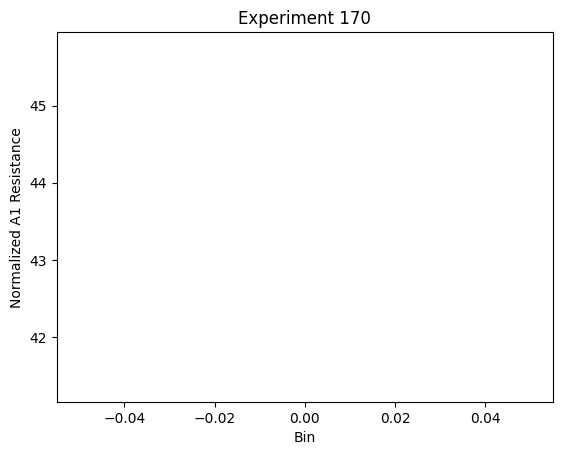

In [106]:
# plot selected exp_no normalized data against bin 
# specify the exp_no to plot

def _plot_norm_data(norm_averaged: pd.DataFrame, exp_no: int) -> None:
    grouped = norm_averaged.groupby('exp_no')
    for name, group in grouped:
        if name == exp_no:
            plt.plot(group['bin'], group['SHT40_Humidity'])# group['norm_A1_Resistance'])
            plt.xlabel('Bin')
            plt.ylabel('Normalized A1 Resistance')
            plt.title(f'Experiment {exp_no}')
            plt.show()

_plot_norm_data(selected_df, 170)

In [13]:
def sample_file(averaged: pd.DataFrame, exp_no: int) -> None:
    sample = averaged.loc[exp_no]['A1_Resistance']
    return sample
_sample_ = sample_file(averaged, 0)
_sample_.to_csv(f"../data/02_intermediate/sample.csv")

In [81]:
# load this file and turn it into a df to read the head() data/03_primary/model_input_table.csv
df_node_out = pd.read_csv('../data/03_primary/model_input_table.csv')
df_node_out.()



,bin_0,bin_1,bin_2,bin_3,bin_4,bin_5,bin_6,bin_7,bin_8,bin_9,...,bin_1490,bin_1491,bin_1492,bin_1493,bin_1494,bin_1495,bin_1496,bin_1497,bin_1498,bin_1499
0,1.312668e+06,1312033.560,1.312850e+06,1312849.435,1.315210e+06,1317487.810,1321880.245,1.321239e+06,1326577.310,1.327317e+06,...,1.361376e+06,1355109.500,1.349278e+06,1.342545e+06,1338308.935,1.332702e+06,1328519.185,1.323631e+06,1320229.870,1.318492e+06
1,1.317396e+06,1318035.560,1.319590e+06,1319406.120,1.323260e+06,1324363.060,1327410.875,1.328427e+06,1332700.685,1.334378e+06,...,1.364479e+06,1357416.560,1.351375e+06,1.345666e+06,1341130.500,1.336809e+06,1331863.560,1.326762e+06,1325192.250,1.324916e+06
2,1.322156e+06,1322431.245,1.324179e+06,1325748.120,1.327871e+06,1329075.000,1332420.750,1.334377e+06,1336902.810,1.339436e+06,...,1.361374e+06,1355973.245,1.348325e+06,1.344529e+06,1340848.375,1.334938e+06,1332699.060,1.331024e+06,1329353.000,1.330467e+06
3,1.328241e+06,1329353.310,1.332141e+06,1332978.875,1.336248e+06,1338027.310,1340848.375,1.343772e+06,1346521.560,1.348134e+06,...,1.370336e+06,1364379.620,1.358284e+06,1.354822e+06,1347658.935,1.343585e+06,1340000.185,1.336809e+06,1335219.435,1.334005e+06
4,1.332327e+06,1332978.370,1.334564e+06,1336059.750,1.339061e+06,1343110.625,1341695.310,1.346045e+06,1347088.935,1.350229e+06,...,1.378009e+06,1371703.000,1.367593e+06,1.362729e+06,1356842.245,1.350421e+06,1345950.245,1.343017e+06,1342261.185,1.337558e+06
